### Walmart Sales Forecasting - Using Auto ARIMA

In [47]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

#### Data Preprocessing

In [48]:
# importing the dataset

df = pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [49]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [50]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst = True)
df = df.drop_duplicates(subset='Date', keep='first')
df.set_index('Date',inplace= True)
df = df.resample('W-FRI').sum()
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


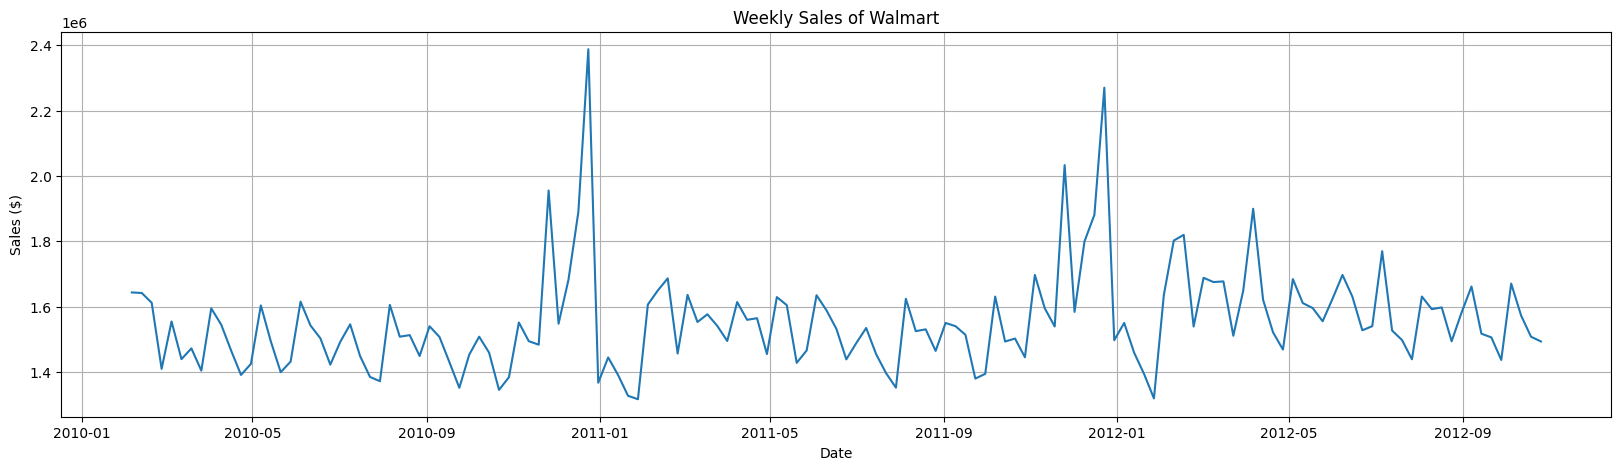

In [51]:
# plotting Weekly sales

plt.figure(figsize=(20,5))
plt.plot(df['Weekly_Sales'], label = 'Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.title('Weekly Sales of Walmart')
plt.grid()
plt.show()

#### Seasonality test

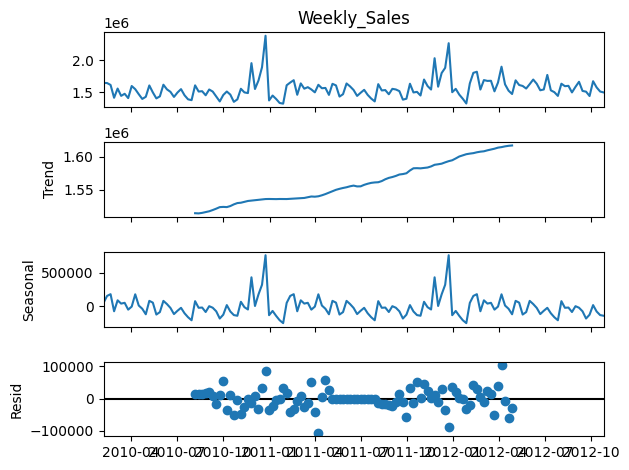

In [52]:
# seasonality check

from statsmodels.tsa.seasonal import seasonal_decompose

snl = seasonal_decompose(df['Weekly_Sales'])
snl.plot()
plt.show()

#### Stationarity test

In [53]:
# stationarity check

from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print('Dickey Fuller test results')
    adf = adfuller(timeseries,autolag ='AIC')
    adf_output = pd.Series(adf[0:4],index = ['Test Statistics','p-value','No of lags','No of Observations'])
    for key,value in adf[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print(adf_output)

In [54]:
adf_test(df['Weekly_Sales'])

Dickey Fuller test results
Test Statistics          -5.102186
p-value                   0.000014
No of lags                4.000000
No of Observations      138.000000
Critical Value (1%)      -3.478648
Critical Value (5%)      -2.882722
Critical Value (10%)     -2.578065
dtype: float64


p < 0.05 . Therefore, the time series is stationary.

In [55]:
# if p > 0.05, differencing is required. In that case use the following code for differencing.

#df['Sales_Diff'] = df['Weekly_Sales'].diff().dropna()
#result_diff = adfuller(df['Sales_Diff'].dropna())
#print(f"ADF after differencing: {result_diff[1]}")

#### Identifying SARIMA Orders [p,d,q][P,D,Q,s]

In [56]:
model = auto_arima(
    df['Weekly_Sales'],
    seasonal= True,
    m = 52, # weekly data, yearly seasonality
    stepwise= True,
    trace= True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=3786.582, Time=3.22 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3850.005, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3795.624, Time=0.68 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3798.433, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3848.013, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=3795.311, Time=2.46 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=3786.204, Time=1.86 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=3819.024, Time=0.16 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=3786.589, Time=46.16 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=3788.572, Time=28.20 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=3785.525, Time=3.90 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=3819.410, Time=0.36 sec
 ARIMA(1,1,2)(2,0,0)[52] intercept   : AIC=inf, Time=56.40 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=3786.145, Time=3.43 sec
 ARIMA(1,1,2)(0,0,1)[

Best model : SARIMA(1,1,1)(1,0,0,52)